In [574]:
%matplotlib inline
from gym import spaces
import json
import datetime as dt
from tensorflow.keras.models import *
from matplotlib import pyplot as plt
import gym
from tqdm import tqdm 
COLAB = False
if not COLAB:
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras import Input
from utils import ReplayBuffer, OrnsteinUhlenbeckActionNoise
path_base = "./"
RESUME = True

In [575]:
Params = {
    'num_stocks' : 10000000,
    'min_brokerage' : 0,
    'brokerage_rate' : 0.01,
    'balance_normal' : 1000000,
    'volume_normal' : 1,
    'shares_normal' : 1000,
}
# state space: OHLC price for each stock, shares of each stock owned, balance
class StockEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, train = True, params = None):
        super(StockEnv,self).__init__()
        if params is None:
            params = {
                    'num_stocks' : len(df),
                    'min_brokerage' : 100,
                    'brokerage_rate' : 0.01,
                    'balance_normal' : 10000000,
                    'volume_normal' : 1,
                    'shares_normal' : 10000000,
                    }
            
        self.num_stocks = params['num_stocks']
        self.min_brokerage = params['min_brokerage']
        self.brokerage_rate = params['brokerage_rate']
        self.balance_normal = params['balance_normal']
        self.shares_normal = params['shares_normal']
        self.volume_normal = params['volume_normal']
        self.dfs = df
        self.state_dimensions = 6
        self.train = train

        assert len(df) == self.num_stocks, "Size of database not equal to number of stocks"

        self.max_steps = min([len(d.loc[:,'Open']) for d in self.dfs])
        self.action_space = spaces.Box(low = -1, high = 1, shape =  (1, self.num_stocks), dtype = np.float32)
        self.observation_space = spaces.Box(low = 0,high = 1,shape = [((self.state_dimensions-1)*self.num_stocks+1)], dtype = np.float32)

    def reset(self, intial_balance = 10000000, shares_held = None):

        if self.train:
            self.current_step = np.random(self.max_steps)
        else:
            self.current_step = 0
        self.balance = intial_balance
        self.shares_held = np.zeros(self.num_stocks)
        if shares_held is not None:
            self.shares_held = shares_held
        self.current_price = self.get_price()
        self.highest_price = 0
        self.net_worth = self.balance + np.sum(self.shares_held*self.current_price)
        self.initial_worth = self.net_worth
        self.max_net_worth = self.net_worth
        self.highest_price = [df.loc[self.current_step, 'High'] for df in self.dfs]
        self.done = False
        self.frame = np.zeros((self.state_dimensions-1)*self.num_stocks +1)
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'highest_price': self.highest_price,
            'net_worth' : self.net_worth,
            'shares_normal': self.shares_normal,
            'balance_normal': self.balance_normal,
            'max_net_worth': self.max_net_worth,
        }
        return  self.observe()
        
    def get_price(self):
        return np.array([np.random.uniform(df.loc[self.current_step,"Open"], df.loc[self.current_step,"Close"]) for df in self.dfs])
      
    def set_high(self):
        high = np.array([df.loc[self.current_step, 'High'] for df in self.dfs])
        self.highest_price = np.maximum(self.highest_price, high)
    
    def validate(self, act):
        x  = True
        sum = 0
        for i in range(self.num_stocks):
            if act[i] < 0:
                if self.shares_held[i] < -act[i]:
                    x=False
            sum += self.broke(self.current_price[i]*abs(act[i]))
        if not x:
            return False, sum
        
        sum += np.sum(self.current_price*act)
        if self.balance-sum < 0:
            return False, sum
        
        print('yay')
        return True, sum

    def observe(self):
        frame = np.zeros(((self.state_dimensions-2),self.num_stocks))
        for i in range(self.num_stocks):
            frame[:4,i] = np.array([self.dfs[i].loc[self.current_step,'Open'],self.dfs[i].loc[self.current_step,'High'],self.dfs[i].loc[self.current_step,'Low'],self.dfs[i].loc[self.current_step,'Close']])
#         print(frame, self.shares_held,self.balance)
        frame[:4, :] /= self.highest_price
        self.frame[:((self.state_dimensions-2)*self.num_stocks)] = np.reshape(frame.T,((self.state_dimensions-2)*self.num_stocks))
        self.frame[((self.state_dimensions-2)*self.num_stocks):((self.state_dimensions-1)*self.num_stocks)] = self.shares_held/self.shares_normal
        self.frame[((self.state_dimensions-1)*self.num_stocks)] = self.balance/self.balance_normal
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'highest_price': self.highest_price,
            'shares_normal': self.shares_normal,
            'balance_normal': self.balance_normal,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
        }
        return self.frame, self.info
        
    def broke(self,amount):
        return max(amount * self.brokerage_rate, self.min_brokerage)
    
    def update(self, reward):
        self.net_worth += reward
        self.max_net_worth = max(self.max_net_worth, self.net_worth)
    
    def take_action(self, action):
        action *= self.shares_normal
        self.current_price = self.get_price()
        validation = self.validate(action)
        if not validation[0]:
            return -validation[1], False
        self.set_high()
        self.balance -= validation[1]
        self.shares_held += action
        reward = self.balance + np.sum(self.shares_held * self.current_price) - self.net_worth
        self.update(reward)
        return reward, True
            
    def step(self, action):
        self.current_step += 1
        if self.current_step >= self.max_steps or self.done:
            self.done = True
            return np.zeros((self.state_dimensions-1)* self.num_stocks), 0, self.done, self.info
        reward, status = self.take_action(action)
        self.done = self.net_worth <= self.initial_worth*0.1
        obs, info = self.observe()
        return obs, reward, self.done, info
    
    def render(self, mode='human', close = False):
        profit = self.net_worth - self.initial_worth
        print('Step: {}'.format(self.current_step))
        print('Net Worth: {}'.format(self.net_worth))
        print('Profit: {}'.format(profit))
        
def create_stock_env(locations, train=True, params = None): 
    dfs = [pd.read_csv(location).sort_values('Date') for location in locations]
    return StockEnv(dfs, train, params)

In [576]:
class Actor:
    def __init__(self, params):
        self.output_range = params["output_range"]
        self.hidden_layers = params["actor_hidden_layers"]
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.actor = self.model()
        
    def model(self):
        inputs = Input(shape=(1,self.state_dimensions))
        x = Lambda(lambda x: x)(inputs)
        for layer in self.hidden_layers:
            x = Dense(layer, activation='relu')(x)
        x = Dense(self.action_dimensions, activation='tanh')(x)
        x = Lambda(lambda x: x*self.output_range)(x)
        model = tf.keras.Model(inputs = inputs, outputs = x)
        return model
    
    def get_action(self, state):
        state_tensor = tf.Variable(shape = state.shape, initial_value = state.astype('float32'))
        #print('before')
        #print(state_tensor)
        act = (self.actor(state_tensor)).numpy()
        #print('after')
        #print(act)
        return act
    
    def save_weights(self):
        self.actor.save_weights(path_base + "actor.h5")
               
    def load_weights(self):
        self.actor.load_weights(path_base + "actor.h5")
        
    
class Critic:
    def __init__(self, params):
        self.hidden_layers = params["critic_hidden_layers"]
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.optimizer = params["critic_optimizer"]
        self.critic_online = self.model()
        self.critic_target = self.model()


    def model(self):
        input_a = Input(shape = (1, self.state_dimensions))
        input_b = Input(shape = (1, self.action_dimensions))
        x = concatenate([input_a, input_b], axis=-1)
        for layer in self.hidden_layers:
            x = Dense(layer, activation='relu')(x)
        x = Dense(1, activation='linear')(x)
        model = tf.keras.Model(inputs=[input_a, input_b], outputs = x)
        model.compile(loss='mse', optimizer=self.optimizer)
        return model
    
    def save_weights(self):
        self.critic_online.save_weights(path_base + "critic_online.h5")
        self.critic_target.save_weights(path_base +  "critic_target.h5")
               
    def load_weights(self):
        self.critic_online.load_weights(path_base + "critic_online.h5")
        self.critic_target.load_weights(path_base + "critic_target.h5")

    def get_qvalues(self, state_array, action_array, online=True):
        state_tensor = tf.Variable(shape = state_array.shape, initial_value = state_array.astype('float32'))
        action_tensor = tf.Variable(shape = action_array.shape, initial_value = action_array.astype('float32'))
        return (self.critic_online([state_tensor, action_tensor]).numpy() if online else self.critic_target([state_tensor, action_tensor]).numpy())
    
    def call(self, state_tensor, action_tensor, online = True):
#         print('before')
#         print(state_tensor)
#         print(action_tensor)
        return (self.critic_online([state_tensor, action_tensor]) if online else self.critic_target([state_tensor, action_tensor]))
    
    def merge_networks(self, tau):
        self.critic_target.set_weights(tau*np.array(self.critic_online.get_weights())
                                                                    + (1-tau)*np.array(self.critic_target.get_weights()))
       

In [577]:
class Agent:
    def __init__(self, params, test=False):
        self.test = test
        self.actor = Actor(params)
        self.critic = Critic(params)
        self.buffer = ReplayBuffer(params["buffer_size"])
        self.state_dimensions = params["state_dimensions"]
        self.action_dimensions = params["action_dimensions"]
        self.discount = params["discount"]
        self.action_range = params["output_range"]
        self.save_frequency = params["save_frequency"]
        self.batch_size = params["batch_size"]
        self.optimizer = params["actor_optimizer"]
        self.tau = params["tau"]
        self.step = 0
        self.noise_func =  OrnsteinUhlenbeckActionNoise(mu=np.zeros(params["action_dimensions"]))
        if RESUME:
            print('loading')
            self.load_networks()
        
        
    def agent_start(self, observation):
        observation = np.reshape(observation, (1, self.state_dimensions))
        act = np.squeeze(self.actor.get_action(observation))
        if not self.test:
            for i in range(act.shape[0]):
                act[i] = np.squeeze(self.clip_action((act[i] + self.noise_func())[0]))
        else:
            for i in range(act.shape[0]):
                act[i] = np.squeeze(self.clip_action(act[i]))
        self.prev_state = observation
        self.prev_action = act
        return act

    def clip_action(self, action):
        if np.abs(action) > self.action_range:
            action *= abs(self.action_range)/abs(action)
        
        return action

    def agent_step(self, reward, observation):
        observation = np.reshape(observation, (1, self.state_dimensions))
        if not self.test:
            relay = (self.prev_state, self.prev_action, reward, observation)
            self.buffer.add(relay)
        self.prev_state = observation
        act = np.squeeze(self.actor.get_action(observation))
        if not self.test:
             for i in range(act.shape[0]):
                self.prev_action[i] = np.squeeze(self.clip_action((act[i] + self.noise_func())[0]))
           # self.prev_action = self.clip_action(act + self.noise_func())
             self.train(self.batch_size)
        else:
            for i in range(act.shape[0]):
                self.prev_action[i] = np.squeeze(self.clip_action((act[i] + self.noise_func())[0]))
            
        return self.prev_action 
    
    def save_networks(self):
        self.actor.save_weights()
        self.critic.save_weights()

    def load_networks(self):
        self.actor.load_weights()
        self.critic.load_weights()


    def train(self, sample_size):
        self.step += 1
        batch, batch_size = self.buffer.sample(sample_size)
        #print(batch)
        state_array = np.array([ element[3] for element in batch])
        #print(state_array.shape)
        #state_array = np.reshape(state_array, (1, self.state_dimensions))
        action_array = self.actor.get_action(state_array)
        prev_state_array = np.array([ element[0] for element in batch])
        prev_action_array = np.array([ [element[1]] for element in batch])
        #print(prev_action_array)
        
#         state_array = np.reshape(state_array, (1,1, self.state_dimensions)) 
#         action_array = np.reshape(action_array, (1,1, self.action_dimensions)) 
#         prev_state_array = np.reshape(prev_state_array, (1,1, self.state_dimensions)) 
#         prev_action_array = np.reshape(prev_action_array, (1,1, self.action_dimensions)) 
        
        output = self.critic.get_qvalues(state_array, action_array, False)
        output = np.array([element[2] + self.discount*out[0] for element, out in zip(batch, output)])
        
        self.critic.critic_online.fit([state_array, action_array], output, verbose=0)

        prev_state_tensor = tf.Variable(shape = prev_state_array.shape, initial_value = prev_state_array.astype('float32'))
        prev_action_tensor = tf.Variable(shape = prev_action_array.shape, initial_value = prev_action_array.astype('float32'))
        
        with tf.GradientTape(persistent=True) as g:
            g.watch(prev_action_tensor) 
            g.watch(prev_state_tensor)
            value = self.critic.call(prev_state_tensor, prev_action_tensor)
            action = self.actor.actor(prev_state_tensor)
            
        gradient = -tf.squeeze(g.gradient(value, prev_action_tensor))
        gradient = tf.cast(gradient, tf.float32)
        gradient_actor = g.gradient(action, self.actor.actor.trainable_weights, gradient)
        gradient_actor = list(map(lambda x: tf.math.divide(x, batch_size), gradient_actor))
        self.optimizer.apply_gradients(zip(gradient_actor, self.actor.actor.trainable_weights))
        self.critic.merge_networks(self.tau)

        if self.step%self.save_frequency == 0:
            self.save_networks()



In [578]:
AGENT_PARAMS = {
	"output_range": 1,
	"actor_hidden_layers": [60, 16],
	"critic_hidden_layers": [60, 16],
	"state_dimensions": 11,
	"action_dimensions": 2,
	"critic_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.01),
	"actor_optimizer": tf.keras.optimizers.Adam(learning_rate = 0.01),
	"batch_size": 64,
	"buffer_size":1000000,
	"discount": 0.99,
	"tau": 0.001,
	"save_frequency": 100
}

In [579]:
files = ['./AAPL.csv','MSFT.csv']
env = create_stock_env(files)

In [ ]:
RESUME = True
def mul_state(y,info):
    for i in range(len(files)):
        y[4*i:4*i+4] = y[4*i:4*i+4]*info['highest_price'][i]
    y[-len(files)-1:-1] = y[-len(files)-1:-1]*info['shares_normal']
    y[-1] = y[-1]*info['balance_normal']
    return y
env = create_stock_env(files,0)
tf.keras.backend.set_floatx('float32')
agent = Agent(AGENT_PARAMS)
ITERATIONS = 2000
N = 10
profit = np.zeros((N,ITERATIONS))
r  = np.zeros((N,ITERATIONS))
action = np.zeros((N,ITERATIONS+1,AGENT_PARAMS["action_dimensions"]))
shares = np.zeros((N,ITERATIONS+1,AGENT_PARAMS["action_dimensions"]))
balance = np.zeros((N,ITERATIONS+1))
for iter in (range(N)):
    prev_profit = 0
    y, info = env.reset()
    y = mul_state(y,info)
    balance[iter,0] = y[-1]
    shares[iter,0,:] = y[-len(files)-1:-1]
    action[iter,0,:] = agent.agent_start(y)
#     print(y,shares[iter,0],balance[iter,0])
#    print(action[iter,0,:])
    for i in tqdm(range(ITERATIONS)):
        y, reward, done, info = env.step(action[iter,i])
        action[iter,i]*= info['current_price']
        y = mul_state(y,info)
        balance[iter,i+1] = y[-1]
        shares[iter,i+1,:] = y[-len(files)-1:-1]
        action[iter,i+1,:] = agent.agent_step(reward, y)
        #print(y,shares[iter,i],balance[iter,i])
        #print(action[iter,i,:])
        profit[iter,i] += reward + prev_profit
        r[iter,i] = reward
        prev_profit += reward
        if done:
            print('x',i)
            break
        for y in range(len(files)):
            if action[iter,i+1,y]<-1 or action[iter,i+1,y]>1:
                print('y',iter,i,y)

  0%|          | 0/2000 [00:00<?, ?it/s]

loading


 84%|████████▍ | 1684/2000 [00:55<00:11, 28.70it/s]

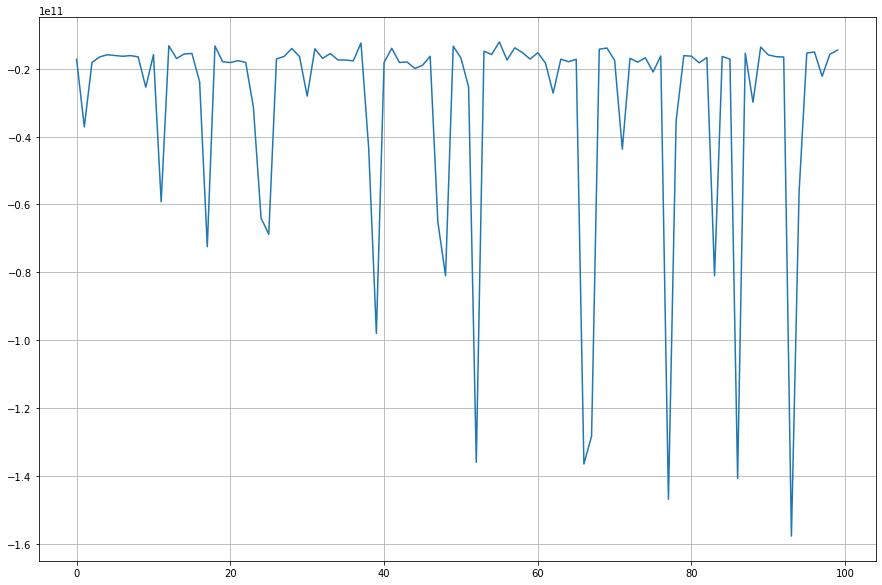

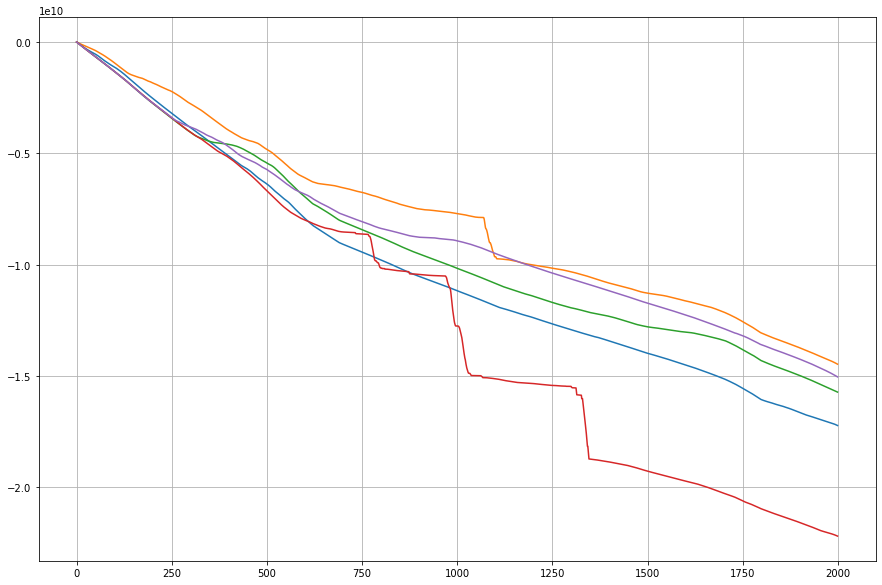

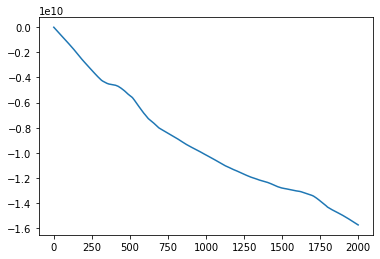

In [636]:
plt.figure(figsize = [15, 10])

plt.plot(profit[:,-1])
plt.grid(True)
plt.show()

plt.figure(figsize = [15, 10])
for i in range(N//20):
    plt.plot(profit[-i,:])
plt.grid(True)
plt.show()

plt.plot(profit[-2,:])
# for i in range(N):
#     plt.plot(r[i,:]>0)
    
# plt.plot(profit[3,:])
# plt.plot(profit[4,:])
# plt.plot(profit[2,:])
# plt.plot(r[2,:])
#plt.legend(['profit '+str(i+1) for i in range(N)] + ['reward '+str(i+1) for i in range(N)])

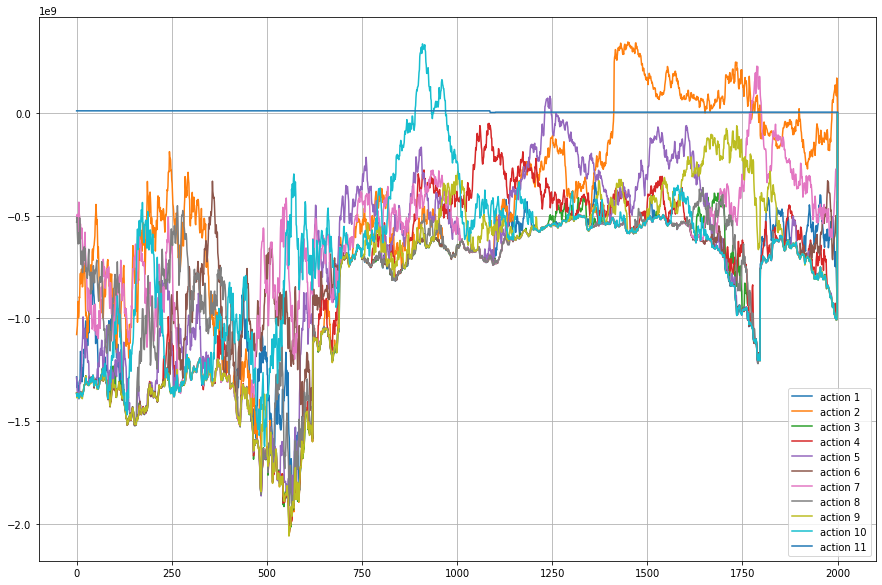

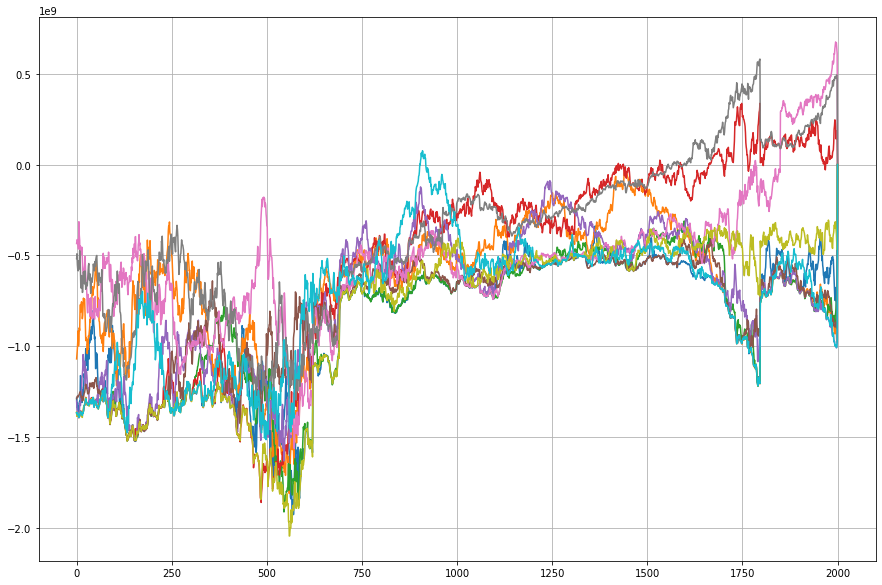

In [632]:
plt.figure(figsize = [15, 10])
#plt.plot(profit[0])
for i in range(N//10):
    plt.plot(action[i,:,0]+action[i,:,1])
    #plt.plot(action[i,:,1])
plt.plot(balance[N-1,:])
#plt.ylim(0,balance[N-1,0]+1900)
plt.legend(['action '+str(i+1) for i in range(N)])

plt.grid(True)
plt.show()
plt.figure(figsize = [15, 10])
for i in range(N//10):
    plt.plot(action[-i,:,0]+action[i,:,1])
plt.grid(True)
plt.show()

In [607]:
action[N-6,250]

array([-2.26773516e+08, -5.30057841e+08])

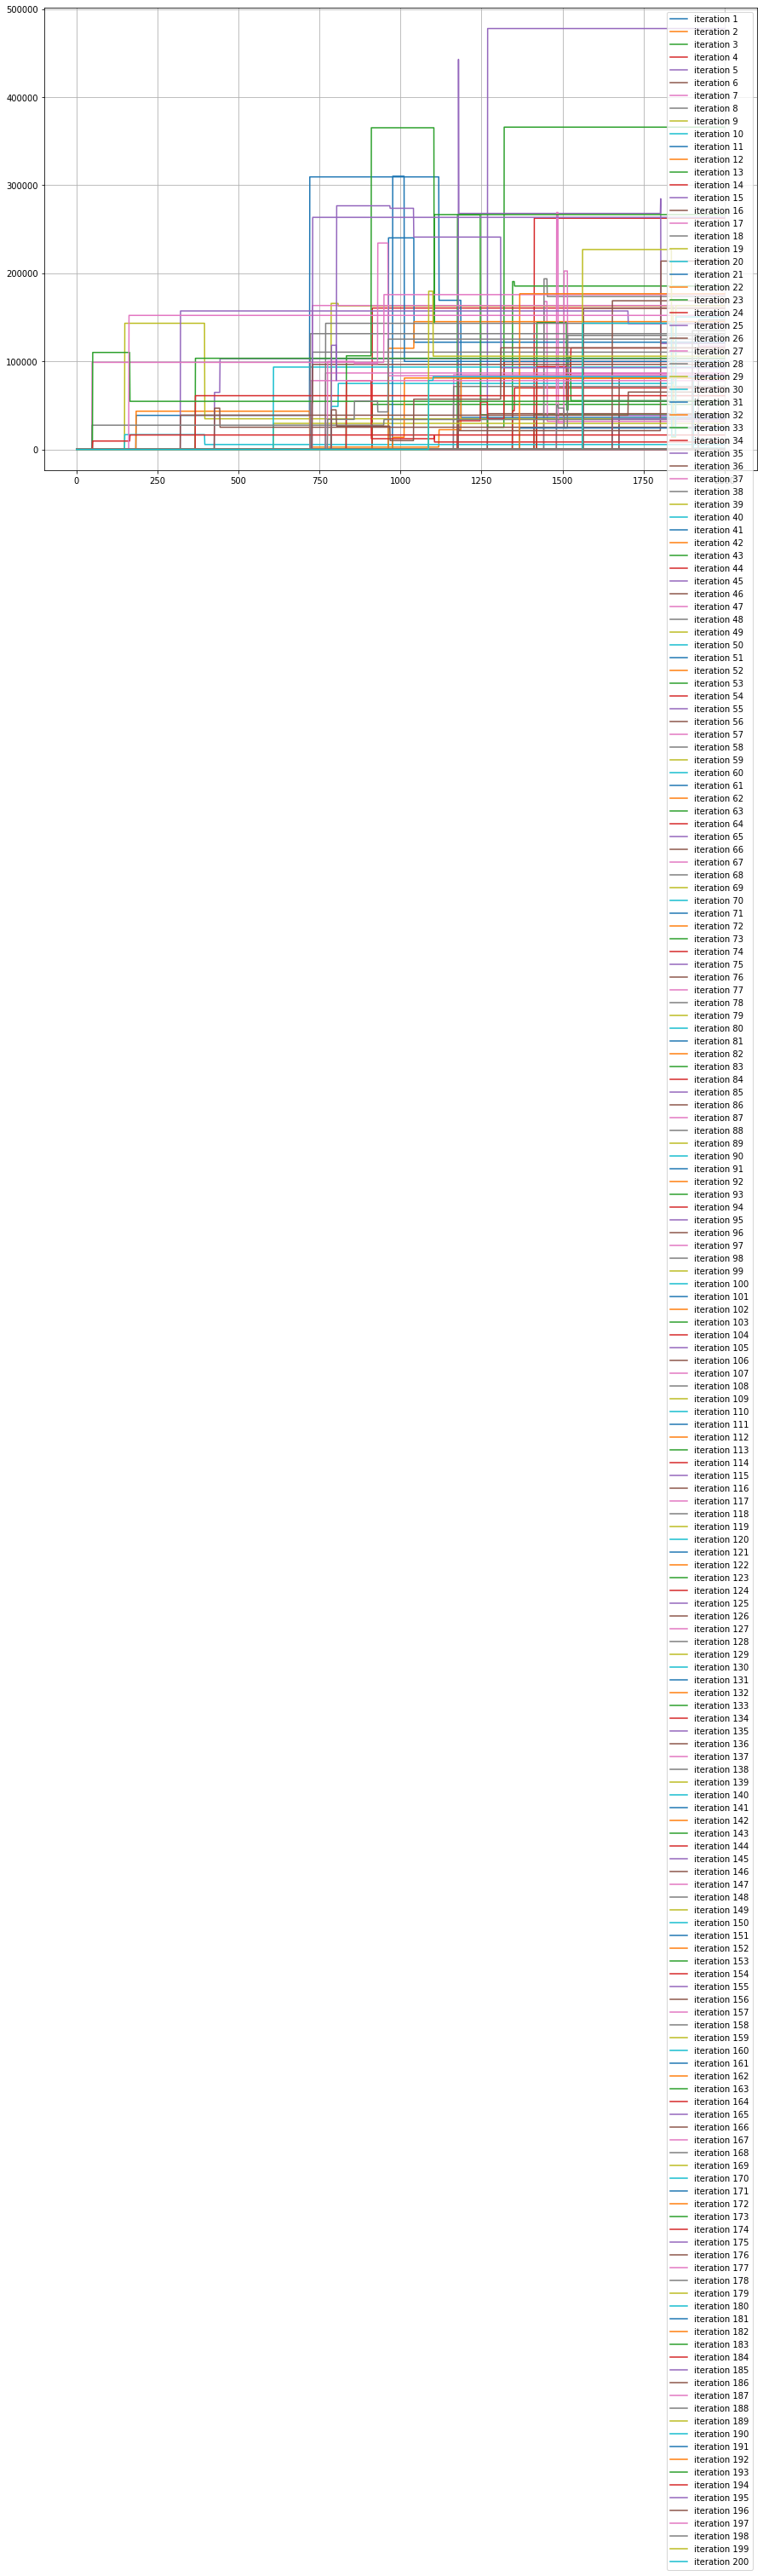

In [640]:
plt.figure(figsize = [15, 10])
for i in range(N):
    plt.plot(shares[i,:,0])
    plt.plot(shares[i,:,1])
plt.legend(['iteration '+str(i+1) for i in range(2*N)])

plt.grid(True)
plt.show()

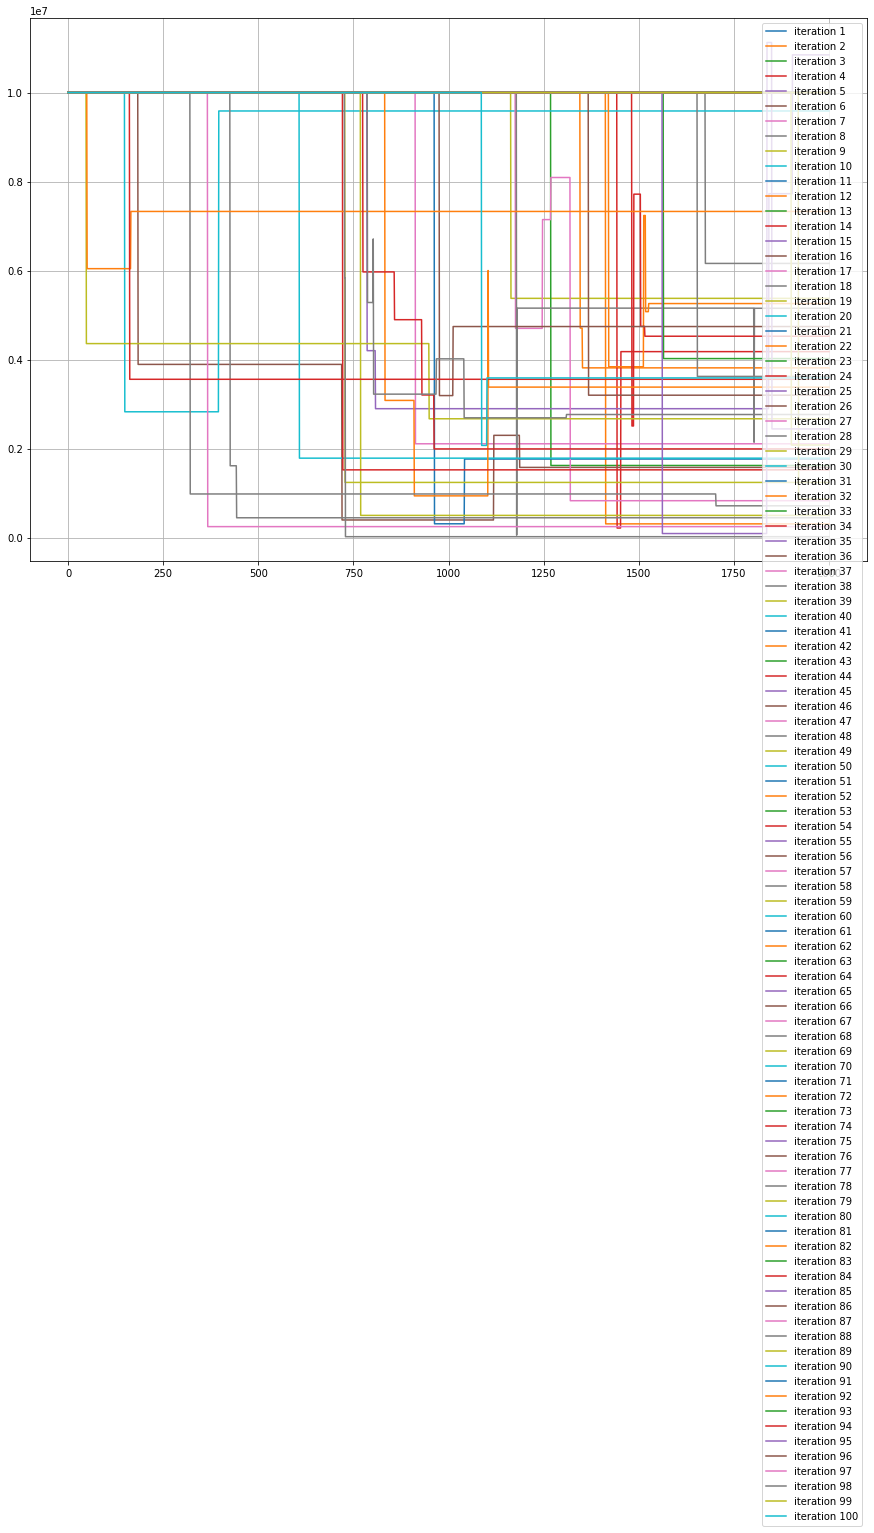

In [618]:
plt.figure(figsize = [15, 10])
for i in range(N):
    plt.plot(balance[i,:])
plt.legend(['iteration '+str(i+1) for i in range(N)])

plt.grid(True)
plt.show()

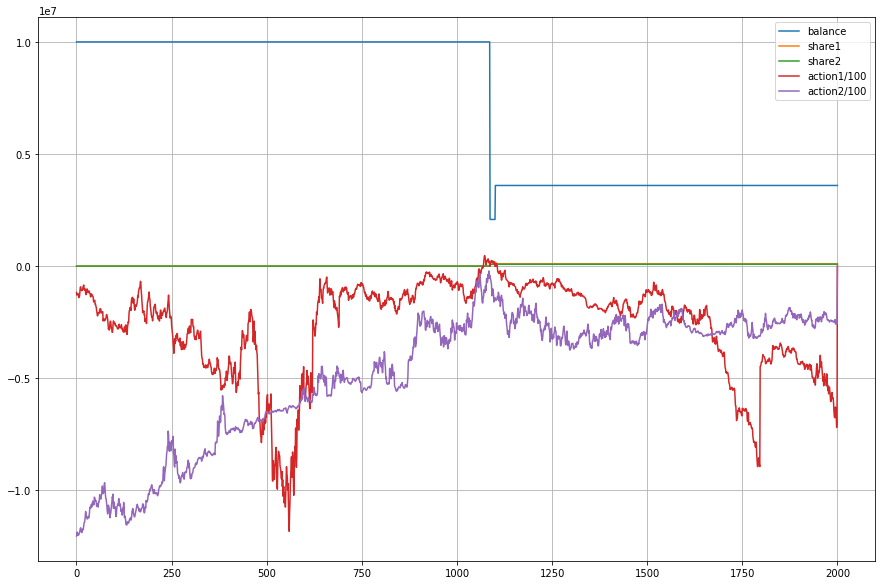

In [624]:
plt.figure(figsize = [15, 10])
plt.plot(balance[N-1,:])
plt.plot(shares[N-1,:,0])
plt.plot(shares[N-1,:,1])
plt.plot((action[N-1,:,0])/100)
plt.plot(action[3,:,1]/100)
#plt.plot(profit[N-1,:])
#plt.plot(r[N-1])
plt.grid(True)
plt.legend(['balance', 'share1', 'share2', 'action1/100', 'action2/100', 'profit', 'reward'])

plt.show()

In [530]:
files = ['IBM.csv', 'KO.csv']
env = create_stock_env(files)
tf.keras.backend.set_floatx('float32')
agent = Agent(AGENT_PARAMS)
ITERATIONS = 20000
profit = np.zeros(ITERATIONS)
action = np.zeros((ITERATIONS+1,AGENT_PARAMS["action_dimensions"]))
shares = np.zeros((ITERATIONS+1,AGENT_PARAMS["action_dimensions"]))
balance = np.zeros(ITERATIONS)
prev_profit = 0
y, info = env.reset()
y[0:-1,:] = y[0:-1,:]*info['highest_price']
y[-1,:] = y[-1,:]*info['max_shares']
action[0,:] = agent.agent_start(y)
for i in tqdm(range(ITERATIONS)):
    shares[i,:] = info['shares_held']
    balance[i] =  info['balance']
    y, reward, done, info = env.step(action[i])
    action[i]*+info['current_prices']
    y[0:-1,:] = y[0:-1,:]*info['highest_price']
    y[-1,:] = y[-1,:]*info['max_shares']
    action[i+1,:] = agent.agent_step(reward, y)
    profit[i] += reward + prev_profit
    prev_profit += reward

loading


AttributeError: 'StockEnv' object has no attribute 'max_step'

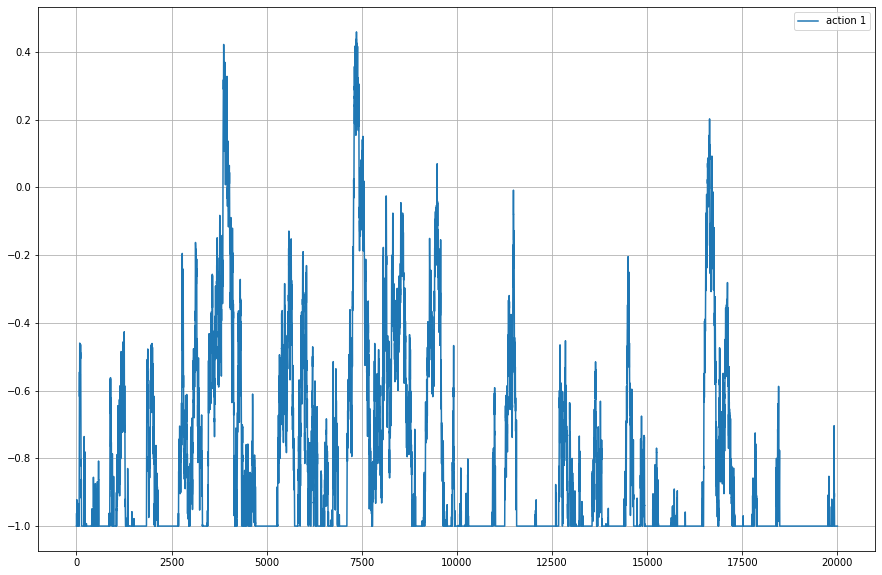

In [31]:
plt.figure(figsize = [15, 10])
#plt.plot(profit[0])
plt.plot(action[:,1])
plt.legend(['action '+str(i+1) for i in range(10)])

plt.grid(True)
plt.show()

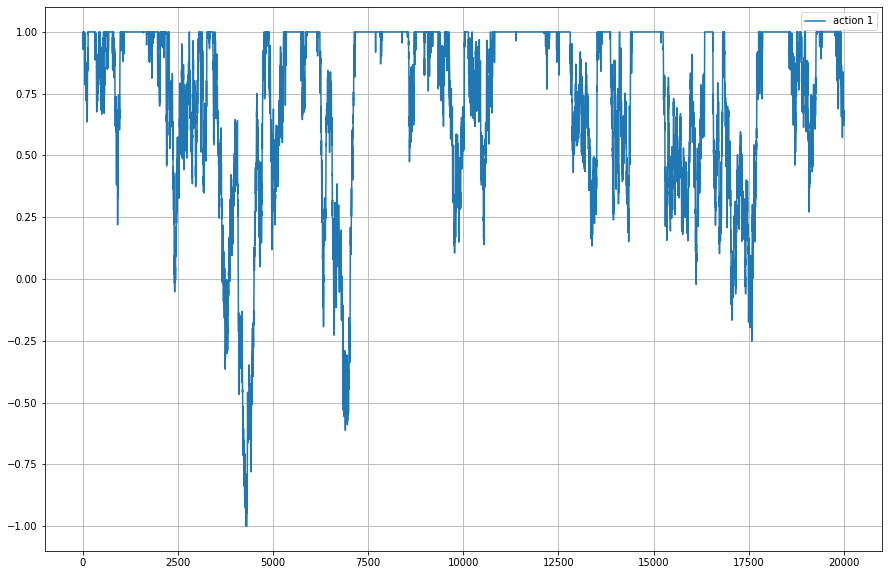

In [100]:
plt.figure(figsize = [15, 10])
#plt.plot(profit[0])
plt.plot(action[:,0])
plt.legend(['action '+str(i+1) for i in range(10)])

plt.grid(True)
plt.show()

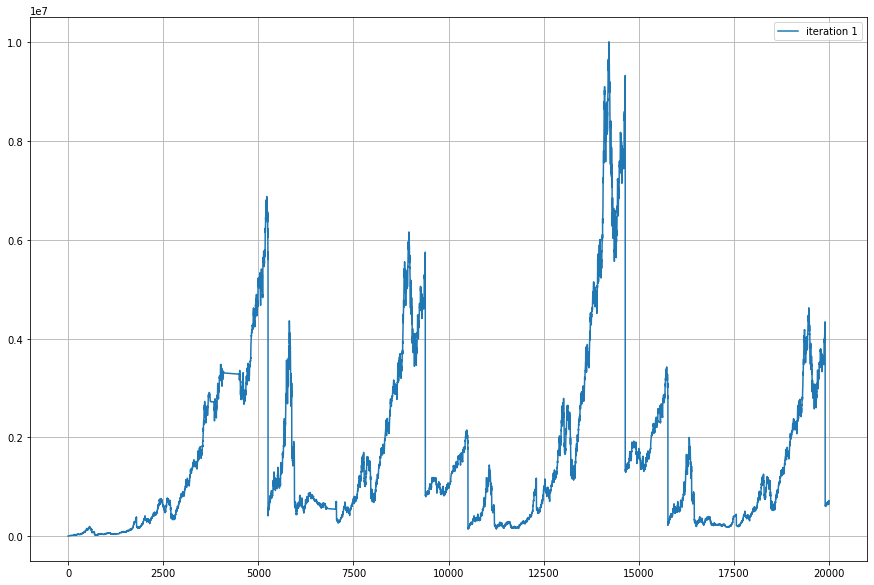

In [101]:
plt.figure(figsize = [15, 10])
#plt.plot(profit[0])
plt.plot(profit)
plt.legend(['iteration '+str(i+1) for i in range(10)])

plt.grid(True)
plt.show()

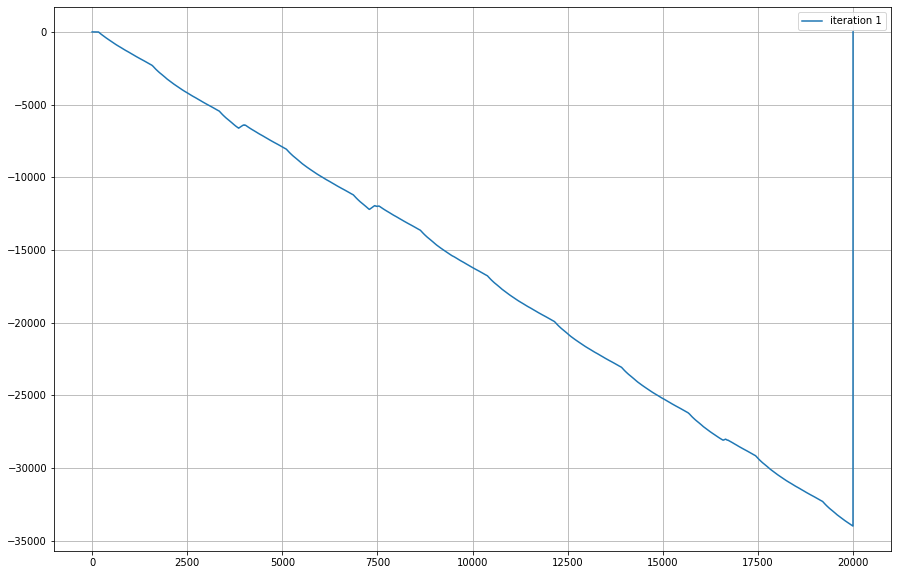

In [29]:
plt.figure(figsize = [15, 10])
plt.plot(shares[:,1])
plt.legend(['iteration '+str(i+1) for i in range(10)])

plt.grid(True)
plt.show()

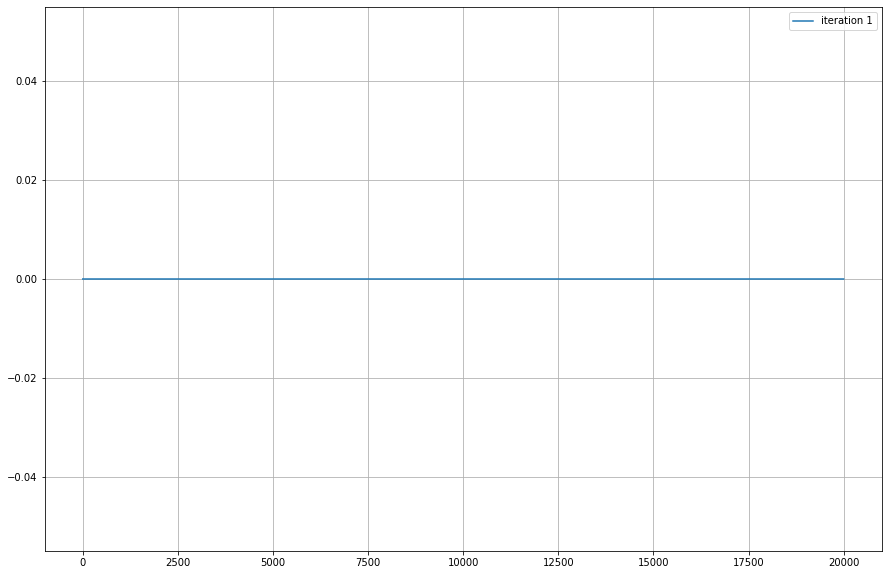

In [32]:
plt.figure(figsize = [15, 10])
plt.plot(shares[:,0]>0)
plt.legend(['iteration '+str(i+1) for i in range(10)])

plt.grid(True)
plt.show()

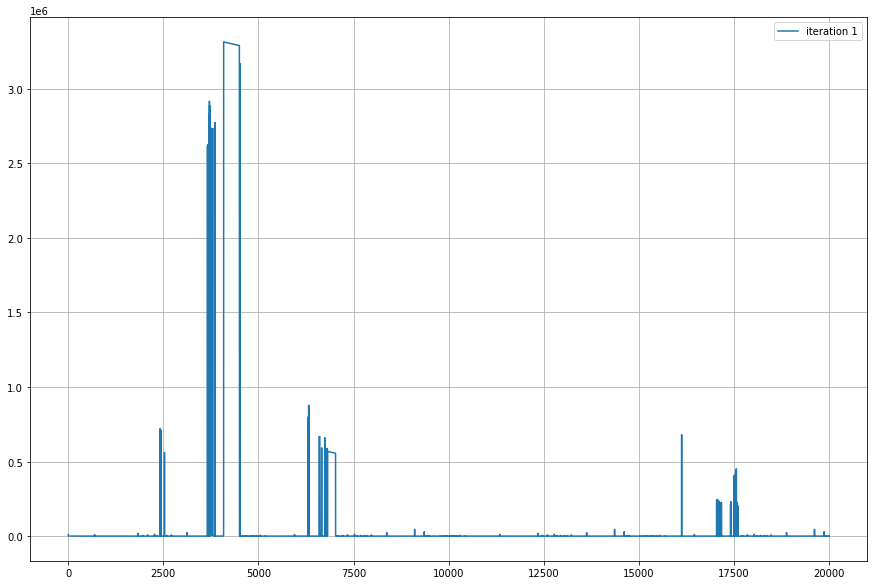

In [125]:
plt.figure(figsize = [15, 10])
plt.plot(balance)
plt.legend(['iteration '+str(i+1) for i in range(10)])
plt.grid(True)
plt.show()